In [1]:
import json
import requests
import datetime

In [2]:
# load proxies from another notebook
%run proxy-load.ipynb

In [3]:
# load the attack file from mitre
mitreJsonFile = 'https://raw.githubusercontent.com/mitre/cti/master/enterprise-attack/enterprise-attack.json'

try:
    attack = requests.get(mitreJsonFile).json()
except:
    attack = requests.get(mitreJsonFile, 
                          proxies=proxies).json()

In [4]:
#define the date
date = datetime.datetime.now().strftime('%Y%m%d')

#give the context of the matrix
context = 'Cloud based services'

# define a title
title = 'ATT&CK - {} {}'.format(context, date)

# plotly color map
color_map = {'handled':'salmon','notHandled':'steelblue','notAppliable':'lightgray'}

#set true for outputs and sample data
demo= True

#any techniques that have been determined to be accounted for
if demo:
    handled_technique = ['Valid Accounts','Account Manipulation','Brute Force','Spearphishing Attachment']
else:
    handled_technique = []


In [5]:
# create a dictionary
technique_listing_tactic = {}
#sample:
# {'T1156': {'tactics': ['persistence'],
#   'name': '.bash_profile and .bashrc',
#   'url': 'https://attack.mitre.org/techniques/T1156'}
tactics = {}
#sample:
#{'TA0009': 'collection',...

for attck_obj in attack['objects']:
    if attck_obj['type'] == 'attack-pattern':
        for external_ref in attck_obj['external_references']:
            if external_ref['source_name'] == 'mitre-attack':
                technique = external_ref['external_id']
                url = external_ref['url']
        technique_listing_tactic[technique] = {}
        technique_listing_tactic[technique]['tactics'] = [tactic['phase_name'] for tactic in attck_obj['kill_chain_phases']]
        technique_listing_tactic[technique]['name'] = attck_obj['name']
        technique_listing_tactic[technique]['url'] = url
    if attck_obj['type'] == 'x-mitre-tactic':
        for external_ref in attck_obj['external_references']:
            if external_ref['source_name'] == 'mitre-attack':
                tactic = external_ref['external_id']
        tactics[tactic] = attck_obj['x_mitre_shortname']
        
tactics_sorted = sorted(tactics)
#sample:
# ['TA0001',
#  'TA0002',...

In [6]:
# displays the unique sources such that users can determine if a source exists in their environment
unique_sources = []

for attck_obj in attack['objects']:
    if attck_obj['type'] == 'attack-pattern':
        try:
            for source in attck_obj['x_mitre_data_sources']:
                if source not in unique_sources:
                    unique_sources.append(source)
        except:
            continue

#unique_sources
# sample:
# ['File monitoring',
#  'Process monitoring',
#  'Process command-line parameters',...

In [7]:
#define the not applicable sources for the context that you are defining the matrix for
if not demo:
    not_applicable_sources = []
else:
    not_applicable_sources = ['BIOS',
                              'Malware reverse engineering',
                              'MBR',
                              'VBR',
                              'Network protocol analysis',
                              'Browser extensions',
                              'Netflow/Enclave netflow',
                              'Disk forensics',
                              'SSL/TLS inspection',
                              'Named Pipes',
                              'Detonation chamber']
    
not_applicable = []

for attck_obj in attack['objects']:
    if attck_obj['type'] == 'attack-pattern':
        try:
            for source in attck_obj['x_mitre_data_sources']:
                if source in not_applicable_sources:
                    not_applicable.append(attck_obj['name'])
        except:
            continue

#show the techniques that you don't have a interest in based on the context and not_applicable_sources
not_applicable = list(set(not_applicable))

if demo:
    not_applicable
#sample:
# ['Network Share Discovery',
#  'Multi-Stage Channels',
#  'Uncommonly Used Port',
#  'Multilayer Encryption',
#  'Spearphishing Link',
#  'Component Firmware',...

In [8]:
temp_list = []
#dictionary defining tactic with name and list of techniques
tactic_listing_techniques = {}
# sample:
# {'TA0009': {'name': 'collection',
#   'techniques': ['Audio Capture',
#    'Automated Collection',
#    'Clipboard Data',...

for tactic in tactics.items():
    for technique in technique_listing_tactic.items():
        if tactic[1] in technique[1]['tactics']:
            temp_list.append(technique[1]['name'])
    tactic_listing_techniques[tactic[0]] = {}
    tactic_listing_techniques[tactic[0]]['name'] = tactic[1]
    tactic_listing_techniques[tactic[0]]['techniques'] = temp_list
    temp_list = []

In [9]:
#matplotlib defination for table
row = 0
notdone = True

#find the number of rows needed to move down
max_techniques = max([len(tactic_listing_techniques[entry]['techniques']) for entry in tactic_listing_techniques]) - 1

#master test list for cells list of lists row by row
cell_texts = []
# sample:
# [['Drive-by Compromise',
#   'AppleScript',
# ...
#   'Commonly Used Port',
#   'Data Destruction'],
#  ['Exploit Public-Facing Application',
#   'CMSTP',
# ...
#   'Communication Through Removable Media',
#   'Data Encrypted for Impact'],
#  ['External Remote Services',
#   'Command-Line Interface',
# ...
#   'Connection Proxy',
#   'Defacement'],...
#built for each row - temp
row_text = []

#master color for each cell
cell_colors = []
row_color = []

while notdone:
    for tactic in tactics_sorted:
        try:
            row_text.append(tactic_listing_techniques[tactic]['techniques'][row])
            if tactic_listing_techniques[tactic]['techniques'][row] in handled_technique:
                row_color.append(color_map['handled'])
            elif tactic_listing_techniques[tactic]['techniques'][row] in not_applicable:
                row_color.append(color_map['notAppliable'])
            else:
                row_color.append(color_map['notHandled'])
        except:
            row_text.append('')
            row_color.append('#ffffff')
    
    cell_texts.append(row_text)
    row_text=[]
    
    cell_colors.append(row_color)
    row_color=[]
    
    if row == max_techniques:
        notdone = False
    
    row += 1


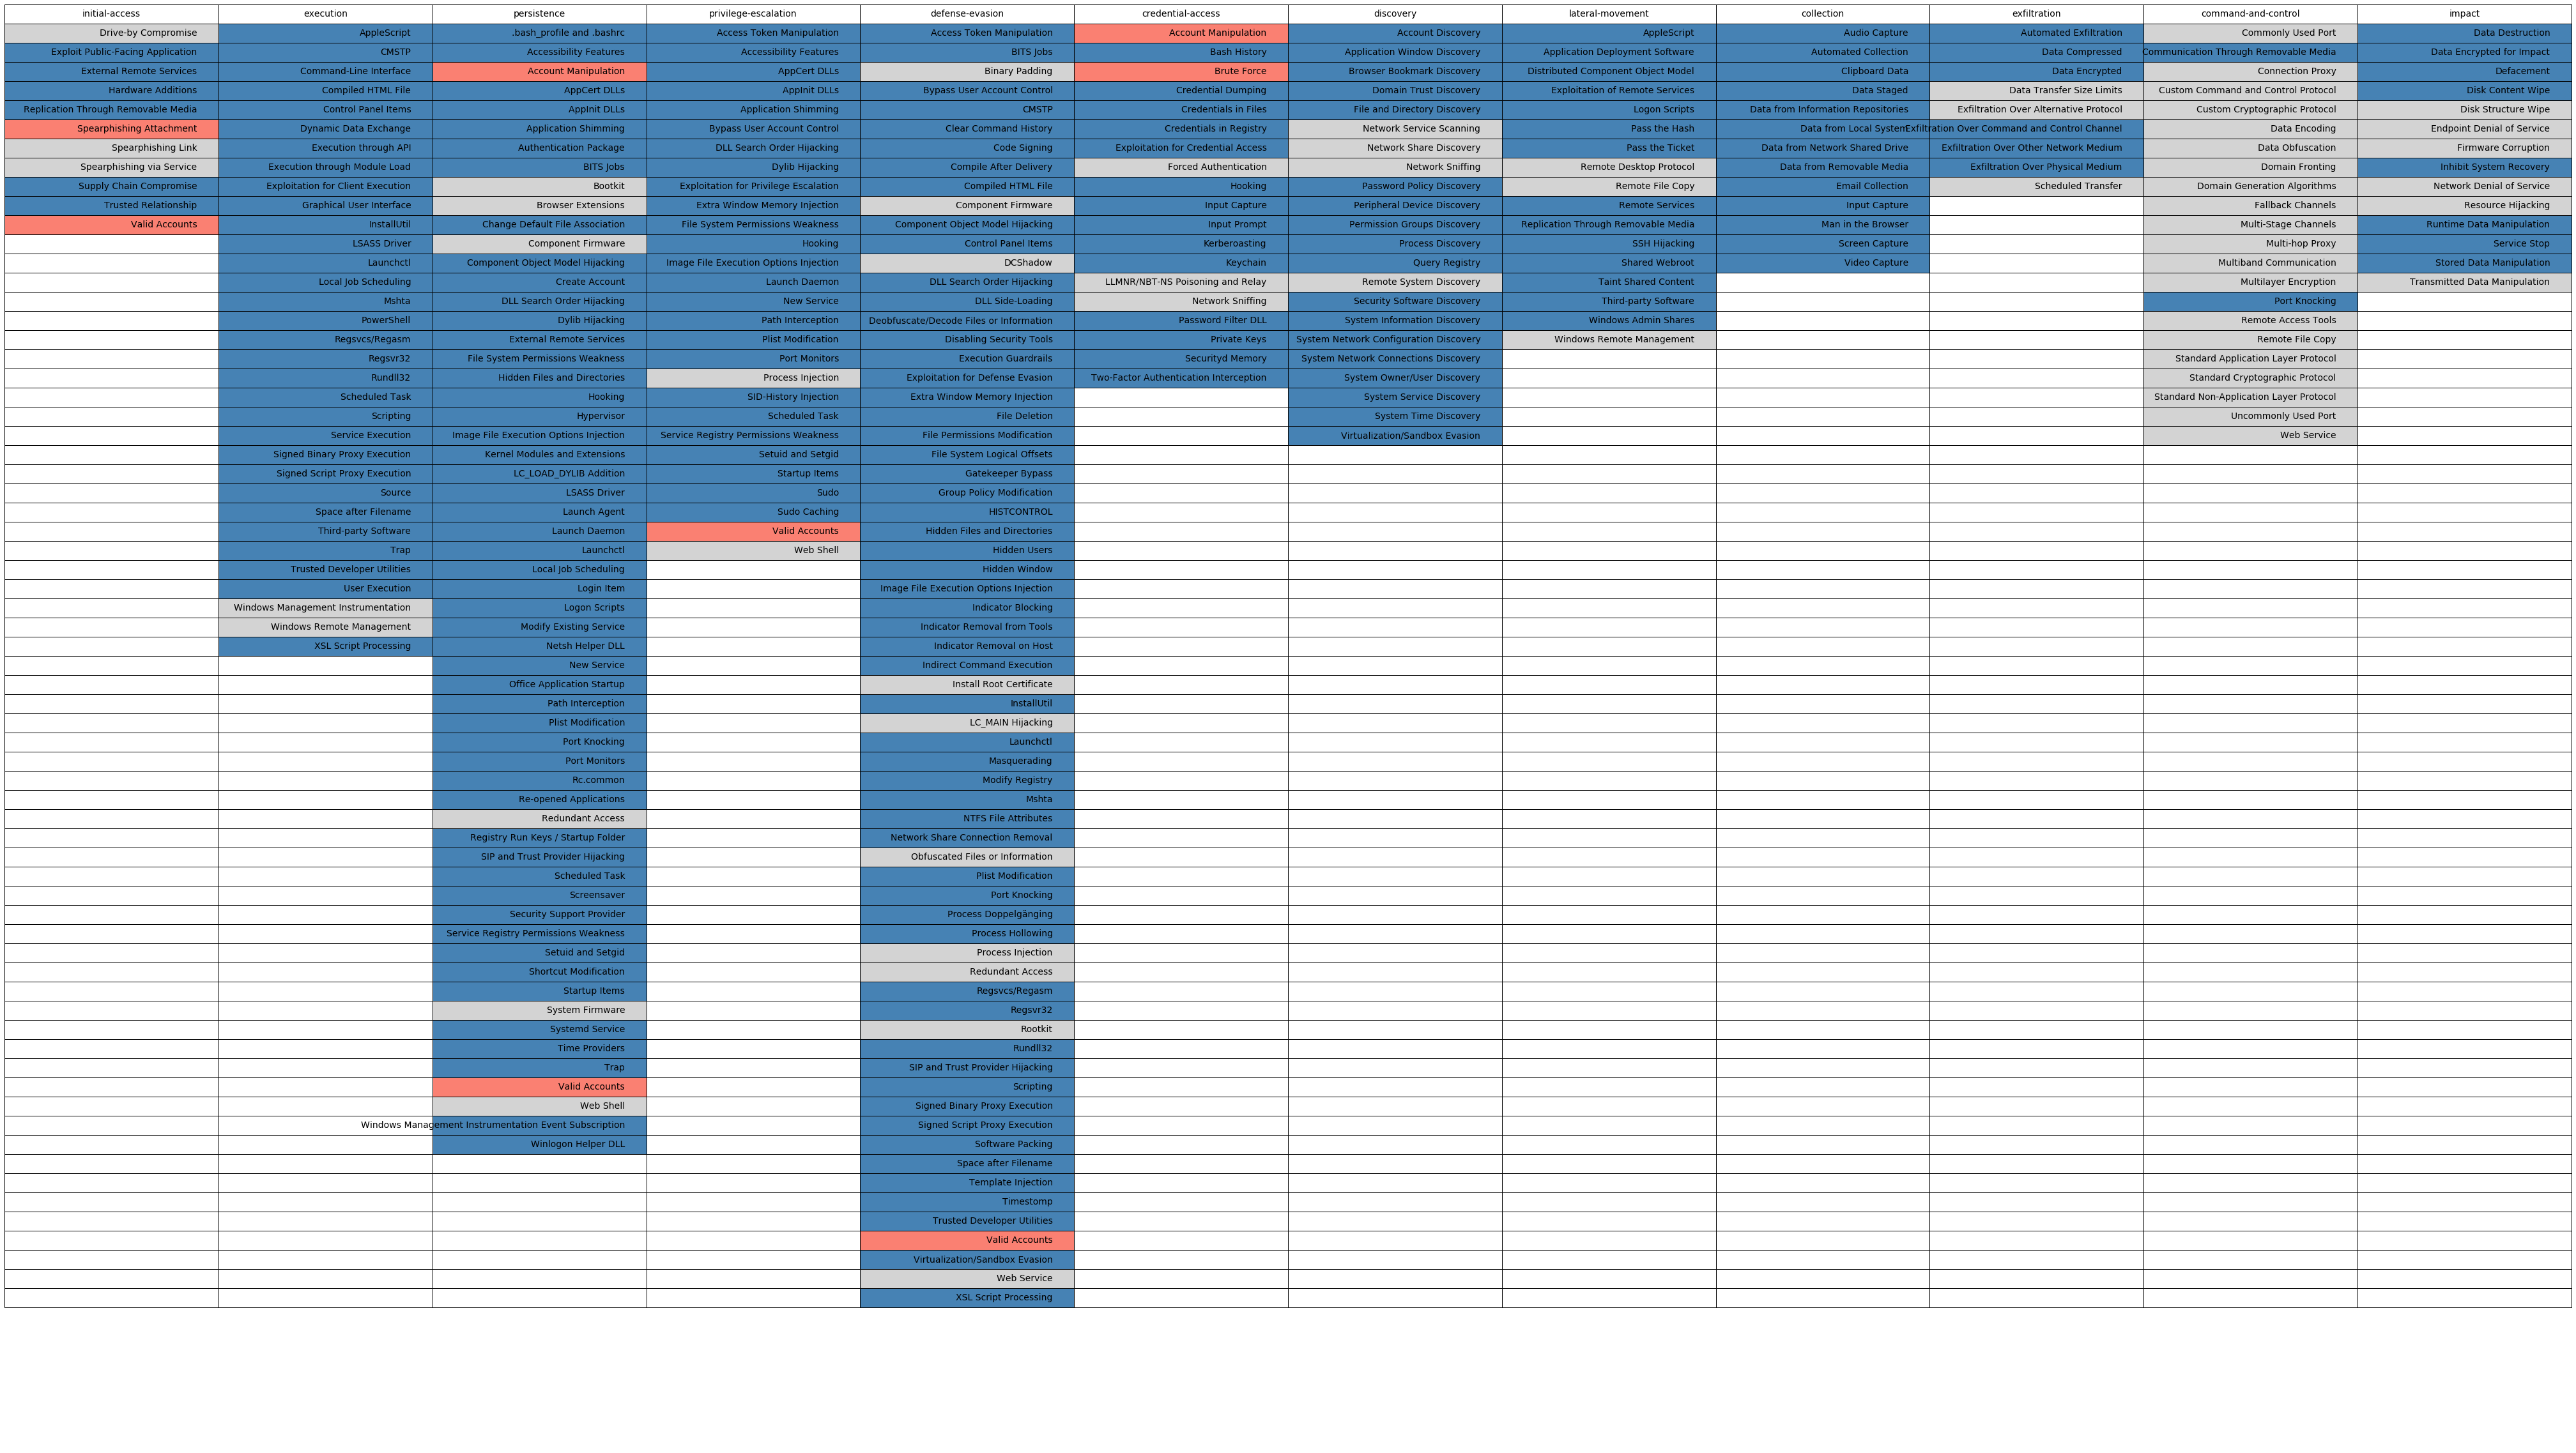

In [11]:
import matplotlib.pyplot as plt

the_table = plt.table(cellText=cell_texts,
                      colLabels=[tactics[tactic] for tactic in tactics_sorted],
                      colWidths=[0.4 for x in tactics_sorted],
                      cellColours = cell_colors,
                      fontsize=32,
                      loc='top')
#params to make it readable if you zoom in
the_table.auto_set_font_size(False)
the_table.set_fontsize(14)
the_table.scale(2.5, 2.5)

#remove all the other junk from the plot
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)

#save it to svg file with high dpi so that it can be zoomed
#if you want this to display in jupyter, the cell will need to be executed twice. 
# this might be overcome with a plt.show() or something
plt.savefig('attack.svg', format='svg', dpi=1200, bbox_inches="tight")

In [12]:
#plotly setup
technique_url_by_name = {value['name']:value['url'] for (key,value) in technique_listing_tactic.items()}
# sample:
# {'.bash_profile and .bashrc': 'https://attack.mitre.org/techniques/T1156',
#  'Access Token Manipulation': 'https://attack.mitre.org/techniques/T1134',...
tactic_listing_techniques_by_name = {}
# sample:
# {'collection': ['Audio Capture',
#   'Automated Collection',
#future use
linked_technique = []

for tactic in tactic_listing_techniques:
    tactic_listing_techniques_by_name[tactic_listing_techniques[tactic]['name']] = tactic_listing_techniques[tactic]['techniques']

#unsupported in present version of data tables - linking url to cell text
#for tactic in tactic_listing_techniques:
#    for technique in tactic_listing_techniques[tactic]['techniques']:
#        linked_technique.append('{0}'.format(technique, technique_url_by_name[technique]))
#    tactic_listing_techniques_by_name[tactic_listing_techniques[tactic]['name']] = linked_technique
#    linked_technique = []


In [13]:
#listing of all techniques
all_techniques = []
# sample:
# ['Audio Capture',
#  'Automated Collection',
#  'Clipboard Data',
#  'Data Staged',
#  'Data from Information Repositories',...

for tacticsTechniques in tactic_listing_techniques_by_name.values():
    for technique in tacticsTechniques:
        all_techniques.append(technique)

In [14]:
#list(tactic_listing_techniques_by_name.keys())
#list(tactic_listing_techniques_by_name.values())

# you might have to install plotly -
# https://plot.ly/python/getting-started/#installation
import plotly.graph_objects as go
import plotly.offline as poff

max_techniques = max([ len(x) for x in list(tactic_listing_techniques_by_name.values())])
max_tactics = len(list(tactic_listing_techniques_by_name.keys()))
colcolor = []
colors = []

for column in list(tactic_listing_techniques_by_name.values()):
    for technique in range(max_techniques):
        try:
            if column[technique] in handled_technique:
                colcolor.append(color_map['handled'])
            elif column[technique] in not_applicable:
                colcolor.append(color_map['notAppliable'])
            else:
                colcolor.append(color_map['notHandled'])
        except:
            colcolor.append('white')
    colors.append(colcolor)
    colcolor = []
#colors = [['salmon']*max_techniques]*(max_tactics-1)
#colors.append(['steelblue']*max_techniques)


fig = go.Figure(data=[go.Table(header=dict(values=['<b>{0:s}</b>'.format(x) for x in list(tactic_listing_techniques_by_name.keys())]),
                               #put things in order like how att&ck is suppose to be
                               columnorder=['8','5','10','11','3','2','4','9','0','1','6','7'],
                               cells=dict(values=list(tactic_listing_techniques_by_name.values()),
                                          fill=dict(color=colors),
                                         ),
                               #name='test',
                               hoverinfo='all',
                               hoverlabel=dict(bordercolor='black'),
                               #hovertext = 'test',
                               )
                     ],
               layout_title_text=title)

fig.update_layout(
    autosize=False,
    width=2000,
    height=2000,
    
    #dragmode='pan'
)

#output the plot to html
poff.plot(fig, filename='matrix.html')


'matrix.html'